<a href="https://colab.research.google.com/github/TimurMMD/AI_LSBF-UEL_project/blob/main/Image_CNN_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mounting the Google Drive with the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


In [4]:
# Define the path to the dataset
data_dir = '/content/drive/My Drive/AI&MV'

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to a fixed size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training, validation, and testing datasets
train_dir = os.path.join(data_dir, 'seg_train/seg_train')
val_dir = os.path.join(data_dir, 'seg_test/seg_test')

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check the number of images in the train and validation sets
print(f'Number of training images: {len(train_dataset)}')
print(f'Number of validation images: {len(val_dataset)}')

Number of training images: 14034
Number of validation images: 3000


In [ ]:
image_0, label_0 = train_dataset[0]
label_0

In [ ]:
image_0.shape

In [7]:
class_name = train_dataset.classes

Image shape: torch.Size([3, 150, 150])


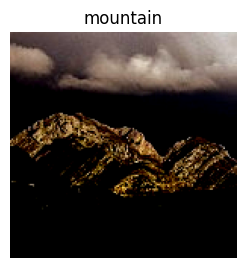

Image shape: torch.Size([3, 150, 150])


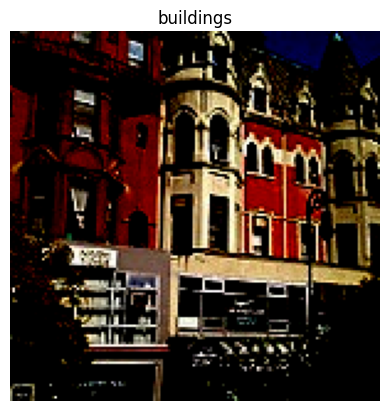

Image shape: torch.Size([3, 150, 150])


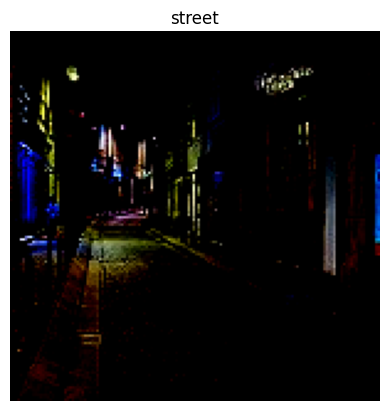

Image shape: torch.Size([3, 150, 150])


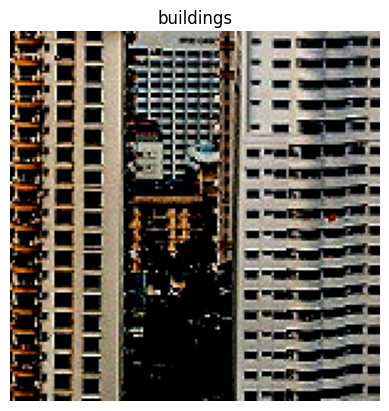

Image shape: torch.Size([3, 150, 150])


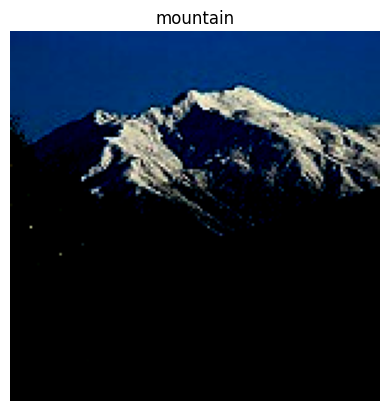

Image shape: torch.Size([3, 150, 150])


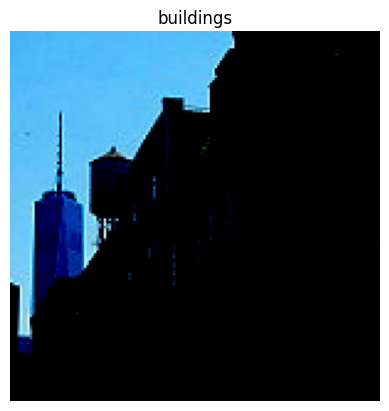

Image shape: torch.Size([3, 150, 150])


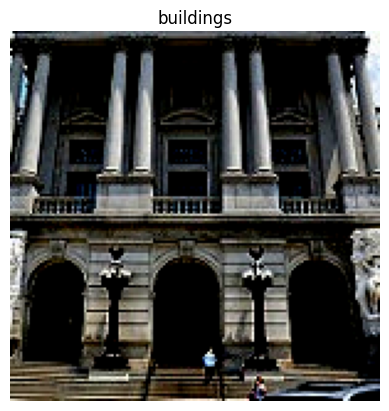

Image shape: torch.Size([3, 150, 150])


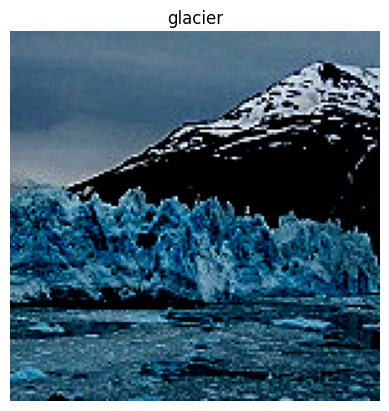

Image shape: torch.Size([3, 150, 150])


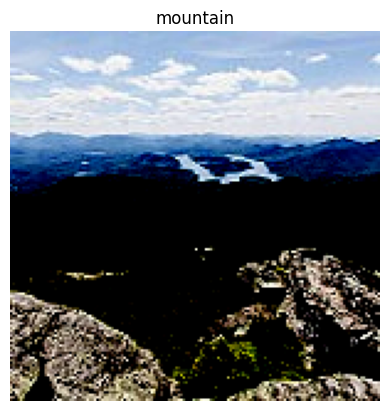

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=(1,)).item()
    image, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    print(f'Image shape: {image.shape}')
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    plt.title(class_name[label])
    plt.axis(False)
    plt.show()

In [9]:
# Load a pretrained ResNet model
model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes in the dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)  # Intel Image Classification has 6 classes

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


In [10]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [11]:
# Check that the model is using GPU
next(model.parameters()).device

device(type='cpu')

In [12]:
from tqdm.auto import tqdm
### Training loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):

    # Set the model to training mode and create the loss variable
    model.train()
    running_loss = 0.0


    for batch, data in enumerate(train_loader, 0):
        # Get the inputs and labels and move them to cuda device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics and record loss values
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}')




    ### Testing loop
    val_loss = 0.0
    correct = 0
    total = 0

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Accuracy: {100 * correct / total:.2f}%')


    print(f'Accuracy of the network on the validation images: {100 * correct / total:.2f}%')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Training Loss: 0.4722
Epoch [1/10], Validation Loss: 0.2633, Accuracy: 87.27%
Accuracy of the network on the validation images: 87.27%
Epoch [2/10], Training Loss: 0.2507
Epoch [2/10], Validation Loss: 0.1761, Accuracy: 91.03%
Accuracy of the network on the validation images: 91.03%
Epoch [3/10], Training Loss: 0.1911
Epoch [3/10], Validation Loss: 1.3562, Accuracy: 92.07%
Accuracy of the network on the validation images: 92.07%
Epoch [4/10], Training Loss: 0.1277
Epoch [4/10], Validation Loss: 0.1032, Accuracy: 91.57%
Accuracy of the network on the validation images: 91.57%
Epoch [5/10], Training Loss: 0.0988
Epoch [5/10], Validation Loss: 0.0222, Accuracy: 90.77%
Accuracy of the network on the validation images: 90.77%
Epoch [6/10], Training Loss: 0.1282
Epoch [6/10], Validation Loss: 0.0882, Accuracy: 91.30%
Accuracy of the network on the validation images: 91.30%
Epoch [7/10], Training Loss: 0.0711
Epoch [7/10], Validation Loss: 0.0146, Accuracy: 91.70%
Accuracy of th

In [15]:
print(train_losses)
print(val_losses)

[0.47221554781825775, 0.2506515753024803, 0.1910670485807867, 0.12766020052168933, 0.09884160327521452, 0.1281880767504708, 0.07109052409520818, 0.04574915509776913, 0.04249315853171652, 0.04101388878348137]
[0.26325565576553345, 0.17614950239658356, 1.3561735153198242, 0.10320831835269928, 0.022158222272992134, 0.08817779272794724, 0.014613468199968338, 0.0010384614579379559, 7.035462476778775e-05, 0.0026609261985868216]


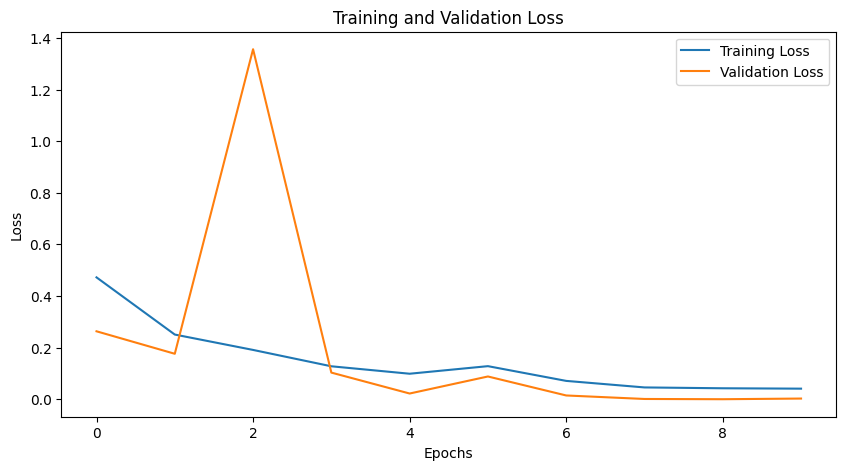

In [16]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()